In [ ]:
"""

https://www.codingfinance.com/post/2019-07-01-analyze-ff-factor-python/

"""

In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import cvxpy as cp
import sys
import warnings

from pypfopt.expected_returns import mean_historical_return, ema_historical_return
from pypfopt.risk_models import CovarianceShrinkage, risk_matrix
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import plotting
from pypfopt import black_litterman, risk_models
from pypfopt.black_litterman import BlackLittermanModel
import seaborn as sns

In [2]:
df = pd.read_excel('test_3_AC.xlsx', skiprows=5, index_col=0,date_parser=True)
df_header = pd.read_excel('test_3_AC.xlsx', skiprows=2, index_col=0,date_parser=True)
df.columns = df_header.columns
df.dropna(inplace=True)
df=df.loc['2001-08-21':,:]
pd.to_datetime(df.index)
cov=df.cov()

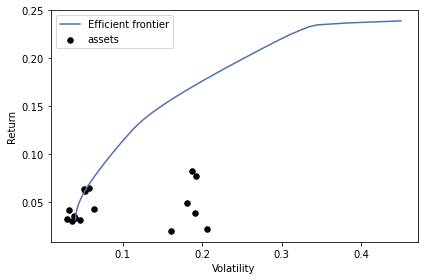

In [3]:
"""
Define expected return and risk models
"""

mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()
risk_free_rate = 0.02
Tgt_Ret = 0.05
Tgt_Vol = 0.042
    
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

<AxesSubplot:>

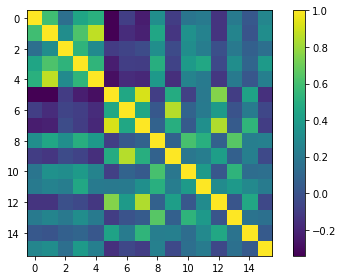

In [4]:
"""
Plotting Variance Covariance Matrix
"""
plotting.plot_covariance(S, plot_correlation=True, show_tickers=False)

Expected annual return: 5.1%
Annual volatility: 3.0%
Sharpe Ratio: 1.05


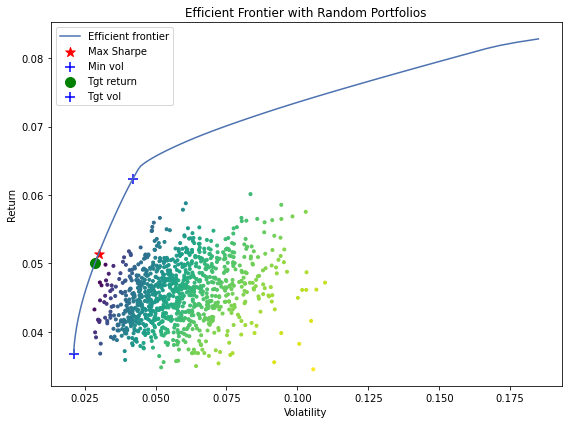

S&P 500 Total Return  MSCI EUROPE NR  TOPIX INDEX (TOKYO)  \
Weights Sharpe                0.01582             0.0                  0.0   
Weights Min Vol               0.00462             0.0                  0.0   
Weights Tgt Ret               0.01560             0.0                  0.0   
Weights Tgt Vol               0.01115             0.0                  0.0   

                 MSCI Daily TR Net Emergi  SMI GROSS TOTAL RETURN  \
Weights Sharpe                        0.0                 0.00000   
Weights Min Vol                       0.0                 0.01066   
Weights Tgt Ret                       0.0                 0.00000   
Weights Tgt Vol                       0.0                 0.00000   

                 U.S. Treasury  Treasury  U.S. Aggregate  \
Weights Sharpe         0.07925   0.08714             0.0   
Weights Min Vol        0.00000   0.09854             0.0   
Weights Tgt Ret        0.06907   0.09514             0.0   
Weights Tgt Vol        0.04917   0.00000             0.0   

                 U.S. Corporate High Yield  Pan-Euro Aggregate  \
Weights Sharpe                     0.19660             0.00000   
Weights Min Vol                    0.00000             0.10104   
Weights Tgt Ret                    0.17484             0.00000   
Weights Tgt Vol                    0.33003             0.00000   

                 Pan-European High Yield  EM Hard Currency Aggregate  \
Weights Sharpe                   0.17860                     0.16033   
Weights Min Vol                  0.00000                     0.00000   
Weights Tgt Ret                  0.16435                     0.14258   
Weights Tgt Vol                  0.28196                     0.32769   

                 LUMSTRUU Index  SPLSTAUSAll Loans  CMBS  BBG Commodity TR  
Weights Sharpe          0.16162            0.12064   0.0           0.00000  
Weights Min Vol         0.39285            0.38497   0.0           0.00733  
Weights Tgt Ret         0.18825            0.15017   0.0           0.00000  
Weights Tgt Vol         0.00000            0.00000   0.0           0.00000

In [5]:
def plot_efficient_frontier_and_portfolios(mu, S, risk_free_rate, Tgt_Ret, Tgt_Vol):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
    
    # Find the max sharpe portfolio
    ef_max_sharpe = EfficientFrontier(mu, S, weight_bounds=(0,1))
    ef_max_sharpe.max_sharpe(risk_free_rate)
    ret_tangent, std_tangent, _ =   ef_max_sharpe.portfolio_performance(risk_free_rate)
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r",     label="Max Sharpe")
    
    # Find the min vol portfolio
    ef_min_vol = EfficientFrontier(mu, S, weight_bounds=(0,1))
    ef_min_vol.min_volatility()
    ret_tangent, std_tangent, _ =   ef_min_vol.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="+", s=100, c="b",     label="Min vol")
    
    # Find the target return portfolio
    ef_ret = EfficientFrontier(mu, S, weight_bounds=(0,1))
    ef_ret.efficient_return(Tgt_Ret)
    ret_tangent, std_tangent, _ =   ef_ret.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="g",     label="Tgt return")
    
    # Find the tgt vol portfolio
    ef_tgt_vol = EfficientFrontier(mu, S, weight_bounds=(0,1))
    ef_tgt_vol.efficient_risk(Tgt_Vol)
    ret_tangent, std_tangent, _ =   ef_tgt_vol.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="+", s=100, c="b",     label="Tgt vol")
    
    

# Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
# Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
        
plot_efficient_frontier_and_portfolios(mu, S, risk_free_rate, Tgt_Ret, Tgt_Vol)

ef_max_sharpe = EfficientFrontier(mu, S, weight_bounds=(0,1))
w_sharpe = ef_max_sharpe.max_sharpe()
cleaned_weights_sharpe = ef_max_sharpe.clean_weights()
df_w = pd.DataFrame(cleaned_weights_sharpe, columns=cleaned_weights_sharpe.keys(), index=['Weights Sharpe'])

ef_min_vol = EfficientFrontier(mu, S, weight_bounds=(0,1))
w_vol = ef_min_vol.min_volatility()
cleaned_weights_vol = ef_min_vol.clean_weights()
df_min_vol = pd.DataFrame(cleaned_weights_vol, columns=cleaned_weights_vol.keys(), index=['Weights Min Vol'])

ef_ret = EfficientFrontier(mu, S, weight_bounds=(0,1))
w_ret = ef_ret.efficient_return(Tgt_Ret)
cleaned_weights_ret = ef_ret.clean_weights()
df_ret = pd.DataFrame(cleaned_weights_ret, columns=cleaned_weights_ret.keys(), index=['Weights Tgt Ret'])

ef_tgt_vol = EfficientFrontier(mu, S, weight_bounds=(0,1))
w_vol = ef_tgt_vol.efficient_risk(Tgt_Vol)
cleaned_weights_vol = ef_tgt_vol.clean_weights()
df_tgt_vol = pd.DataFrame(cleaned_weights_vol, columns=cleaned_weights_vol.keys(), index=['Weights Tgt Vol'])


df_w = pd.concat([df_w,df_min_vol,df_ret,df_tgt_vol])
df_w

In [6]:
df_ret = df.pct_change().dropna()

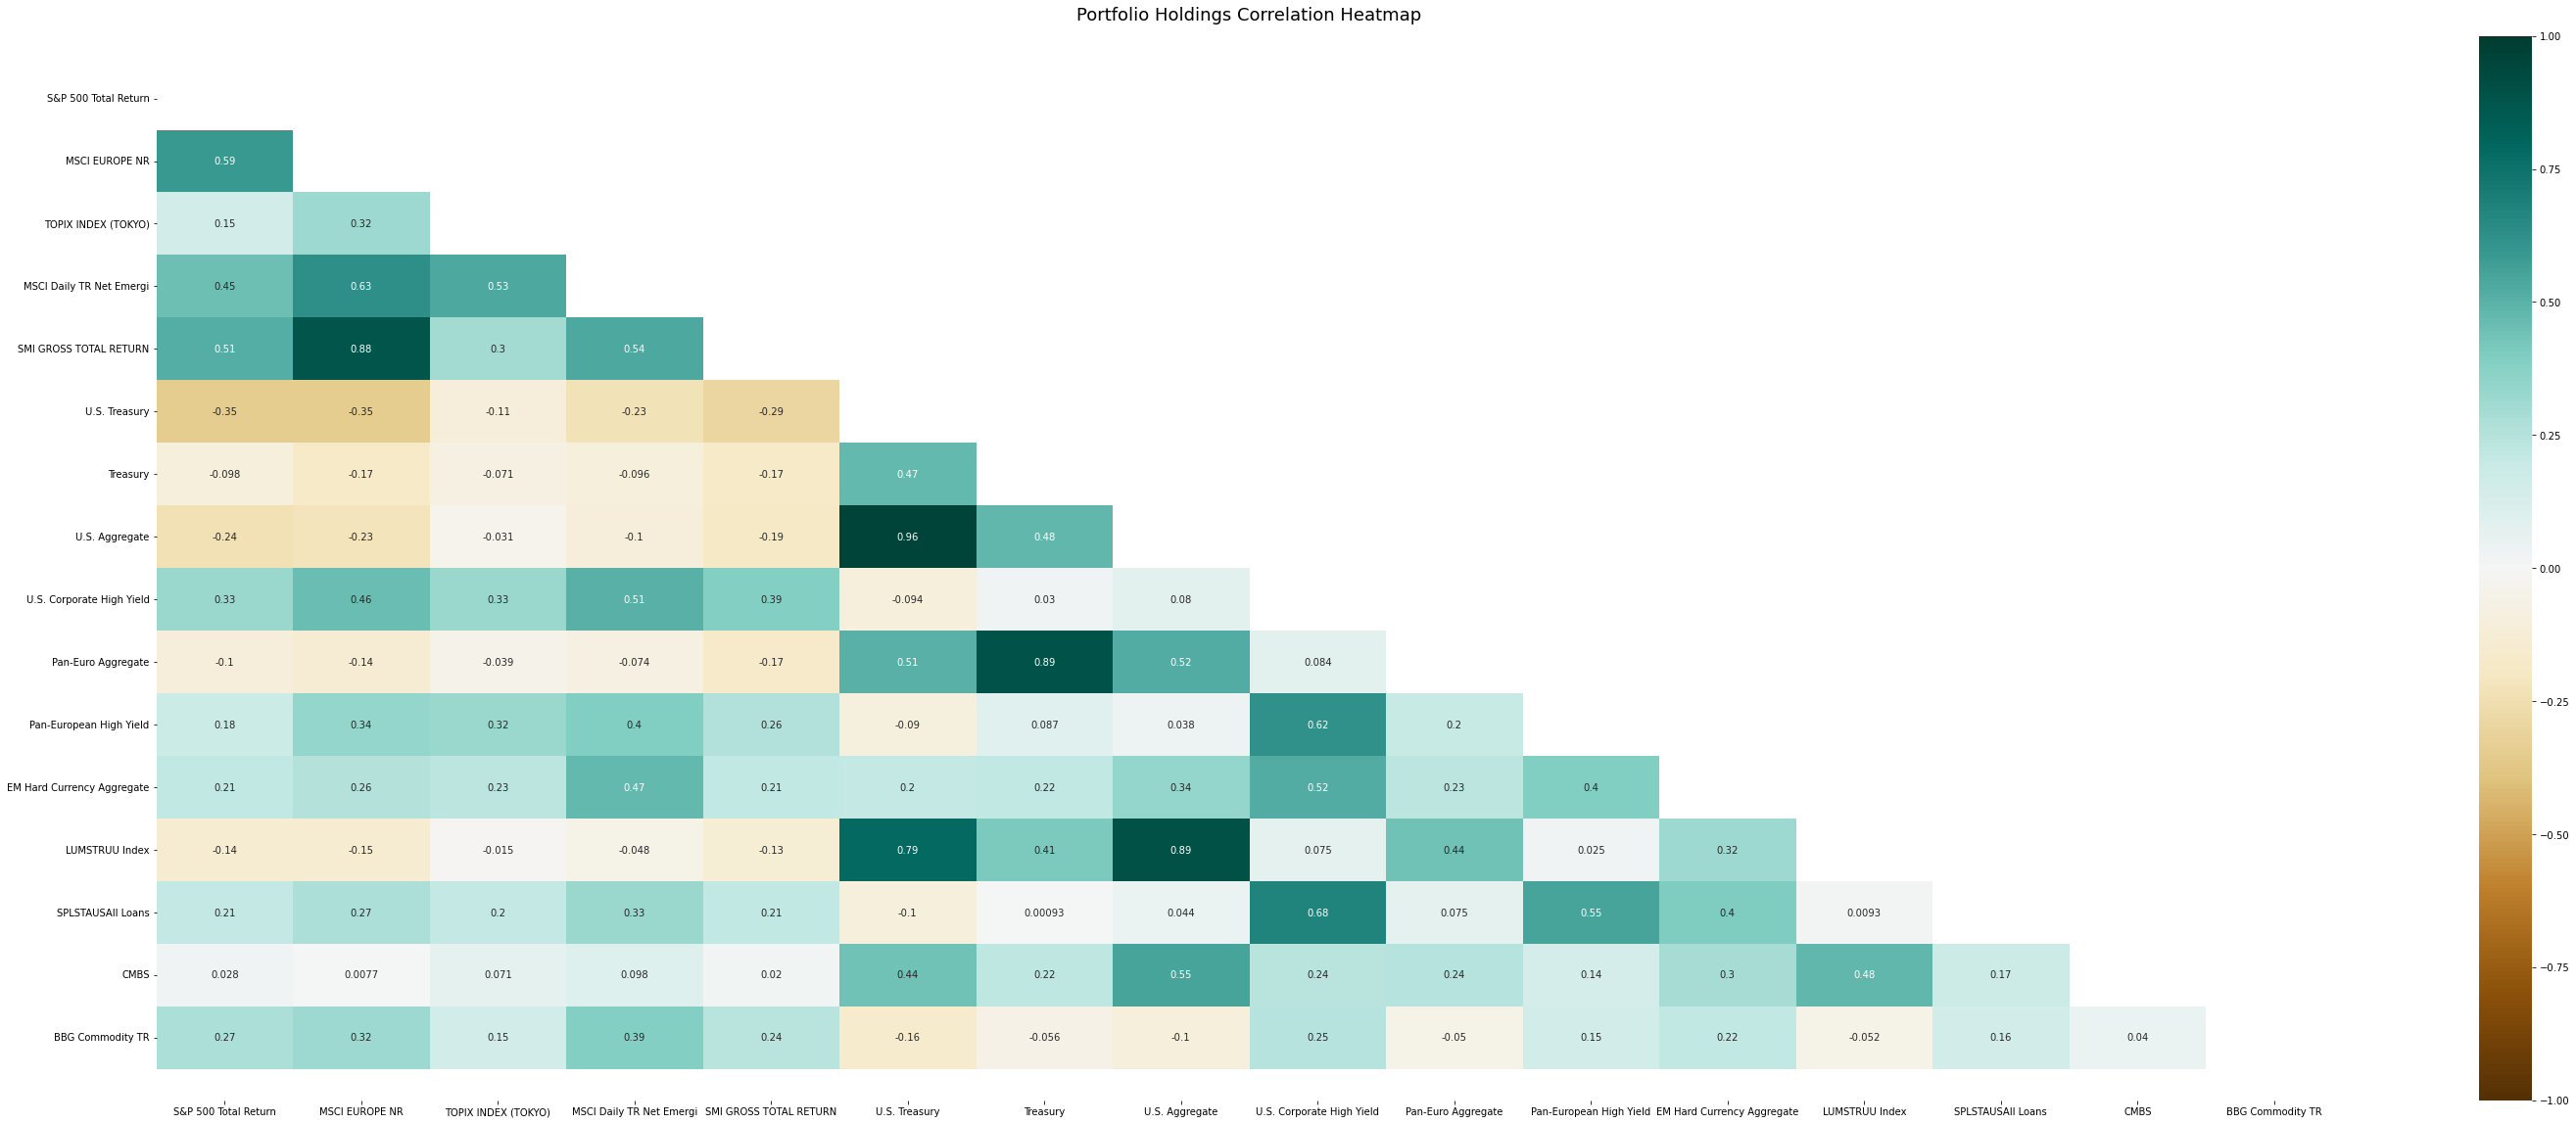

In [7]:
plt.figure(figsize=(50, 20))
mask = np.triu(np.ones_like(df_ret.corr(), dtype='bool'))
ax = sns.heatmap(df_ret.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
ax.set_title('Portfolio Holdings Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('.jpg', dpi=300, bbox_inches='tight')

In [20]:
df_mkt_caps = pd.read_excel('test_3_AC.xlsx', sheet_name='MKT_CAP', skiprows=4, index_col=0,date_parser=True).loc['MKT Cap USD':].transpose()
df_mkt_caps['weights'] = df_mkt_caps['MKT Cap USD'].apply(lambda row: row / df_mkt_caps.sum())

In [21]:
df_mkt_caps

MKT Cap USD   weights
S&P 500 Total Return            33557791.36  0.261652
MSCI EUROPE NR               8821515.116638  0.068782
TOPIX INDEX (TOKYO)          2941568.117781  0.022936
MSCI Daily TR Net Emergi         6594757.83  0.051420
SMI GROSS TOTAL RETURN       1151016.849912  0.008975
U.S. Treasury                   10031860.88  0.078219
Treasury                     7115968.818028  0.055484
U.S. Aggregate                  24763364.44  0.193082
U.S. Corporate High Yield        1300563.45  0.010141
Pan-Euro Aggregate          16071976.520852  0.125314
Pan-European High Yield       428297.211412  0.003339
EM Hard Currency Aggregate       2201854.97  0.017168
LUMSTRUU Index                   6887353.36  0.053701
SPLSTAUSAll Loans                   1400000  0.010916
CMBS                              485475.91  0.003785
BBG Commodity TR                    4500000  0.035087

In [22]:
delta = black_litterman.market_implied_risk_aversion(df)
delta

S&P 500 Total Return           1.966835
MSCI EUROPE NR                 1.006634
TOPIX INDEX (TOKYO)            0.552593
MSCI Daily TR Net Emergi       2.209710
SMI GROSS TOTAL RETURN         1.378578
U.S. Treasury                  6.009439
Treasury                       8.982162
U.S. Aggregate                10.979475
U.S. Corporate High Yield     16.542317
Pan-Euro Aggregate             8.946139
Pan-European High Yield       13.828254
EM Hard Currency Aggregate    15.246184
LUMSTRUU Index                14.864444
SPLSTAUSAll Loans             21.836590
CMBS                           5.873575
BBG Commodity TR               0.489922
dtype: float64

In [23]:
market_caps = df_mkt_caps['MKT Cap USD'].to_dict()
mcaps = pd.Series(market_caps)
mkt_weights = mcaps / mcaps.sum()
mkt_weights

S&P 500 Total Return          0.261652
MSCI EUROPE NR                0.068782
TOPIX INDEX (TOKYO)           0.022936
MSCI Daily TR Net Emergi      0.051420
SMI GROSS TOTAL RETURN        0.008975
U.S. Treasury                 0.078219
Treasury                      0.055484
U.S. Aggregate                0.193082
U.S. Corporate High Yield     0.010141
Pan-Euro Aggregate            0.125314
Pan-European High Yield       0.003339
EM Hard Currency Aggregate    0.017168
LUMSTRUU Index                0.053701
SPLSTAUSAll Loans             0.010916
CMBS                          0.003785
BBG Commodity TR              0.035087
dtype: float64

In [24]:
prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
prior

S&P 500 Total Return          0.043395
MSCI EUROPE NR                0.029598
TOPIX INDEX (TOKYO)           0.022532
MSCI Daily TR Net Emergi      0.038362
SMI GROSS TOTAL RETURN        0.030799
U.S. Treasury                 0.017033
Treasury                      0.021140
U.S. Aggregate                0.019672
U.S. Corporate High Yield     0.048034
Pan-Euro Aggregate            0.021519
Pan-European High Yield       0.037477
EM Hard Currency Aggregate    0.042084
LUMSTRUU Index                0.021766
SPLSTAUSAll Loans             0.034532
CMBS                          0.024348
BBG Commodity TR              0.022136
dtype: float64

In [3]:
ff_fact_ret = pd.read_csv('test_ff.csv',skiprows=4,index_col=0,parse_dates=True).reset_index().iloc[:-1,:]

In [4]:
ff_fact_ret['index'] = pd.to_datetime(ff_fact_ret['index'])

In [5]:
ff_fact_ret

index  Mkt-RF   SMB   HML     RF
0     1926-07-01    0.10 -0.23 -0.28  0.009
1     1926-07-02    0.45 -0.34 -0.03  0.009
2     1926-07-06    0.17  0.29 -0.38  0.009
3     1926-07-07    0.09 -0.59  0.00  0.009
4     1926-07-08    0.21 -0.38  0.18  0.009
...          ...     ...   ...   ...    ...
25246 2022-05-24   -1.23 -0.94  1.84  0.001
25247 2022-05-25    1.22  0.78  0.21  0.001
25248 2022-05-26    2.18  0.20 -0.63  0.001
25249 2022-05-27    2.58  0.35 -1.30  0.001
25250 2022-05-31   -0.71 -0.49  0.44  0.001

[25251 rows x 5 columns]

In [6]:
mom_fact_ret = pd.read_csv('test_mom.csv',skiprows=13,index_col=0,parse_dates=True).reset_index().iloc[:-1,:]

In [7]:
mom_fact_ret['index'] = pd.to_datetime(mom_fact_ret['index'])
mom_fact_ret

index  Mom   
0     1926-11-03    0.56
1     1926-11-04   -0.50
2     1926-11-05    1.17
3     1926-11-06   -0.03
4     1926-11-08   -0.01
...          ...     ...
25145 2022-05-24    2.26
25146 2022-05-25   -0.90
25147 2022-05-26   -0.89
25148 2022-05-27   -0.73
25149 2022-05-31   -0.51

[25150 rows x 2 columns]

In [8]:
ffm_fact_ret = pd.merge(left=ff_fact_ret, right=mom_fact_ret, how='inner',on='index').set_index('index').reset_index()

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [10]:
df_ret = df.pct_change().iloc[1:,:]

In [11]:
df_ret.head()

S&P 500 Total Return  MSCI EUROPE NR  TOPIX INDEX (TOKYO)  \
Dates                                                                   
2001-08-22              0.007033       -0.003641             0.005799   
2001-08-23             -0.002746        0.003209            -0.015572   
2001-08-24              0.019667        0.015016            -0.001787   
2001-08-27             -0.004823        0.001576             0.008583   
2001-08-28             -0.014993       -0.011536            -0.004259   

            MSCI Daily TR Net Emergi  SMI GROSS TOTAL RETURN  U.S. Treasury  \
Dates                                                                         
2001-08-22                  0.003446               -0.010772      -0.000166   
2001-08-23                 -0.001053               -0.006252       0.001967   
2001-08-24                  0.001648                0.014622      -0.001980   
2001-08-27                  0.012293                0.006828      -0.000621   
2001-08-28                 -0.003261               -0.014463       0.004355   

            Treasury  U.S. Aggregate  U.S. Corporate High Yield  \
Dates                                                             
2001-08-22 -0.000617        0.000101                   0.000200   
2001-08-23 -0.000389        0.001554                  -0.001597   
2001-08-24 -0.001835       -0.001088                   0.000091   
2001-08-27  0.000000       -0.000323                   0.000727   
2001-08-28  0.004292        0.003551                   0.000727   

            Pan-Euro Aggregate  Pan-European High Yield  \
Dates                                                     
2001-08-22           -0.001066                -0.000869   
2001-08-23            0.000212                 0.001100   
2001-08-24           -0.001631                 0.000293   
2001-08-27            0.000000                 0.000000   
2001-08-28            0.005134                 0.003025   

            EM Hard Currency Aggregate  LUMSTRUU Index  SPLSTAUSAll Loans  \
Dates                                                                       
2001-08-22                    0.020724        0.000474           0.000000   
2001-08-23                    0.001679        0.001005           0.000000   
2001-08-24                   -0.001403       -0.000599           0.001303   
2001-08-27                   -0.000313       -0.000232           0.000000   
2001-08-28                    0.007181        0.002252           0.000000   

                CMBS  BBG Commodity TR  
Dates                                   
2001-08-22 -0.000409         -0.003253  
2001-08-23  0.001636          0.003175  
2001-08-24 -0.001307         -0.000077  
2001-08-27 -0.000082         -0.000525  
2001-08-28  0.004744         -0.000165

In [12]:
y = df_ret[['S&P 500 Total Return']].reset_index()


X = ffm_fact_ret.set_index('index').loc['2001-08-22':].reset_index()

In [14]:
df_reg = pd.merge(left=X, right=y, how='inner',left_on='index',right_on='Dates').set_index('index').reset_index()

In [17]:
df_reg

index  Mkt-RF   SMB   HML     RF  Mom         Dates  \
0    2001-08-22    0.71  0.30 -0.57  0.013   -0.78 2001-08-22   
1    2001-08-23   -0.31 -0.27 -0.14  0.013    0.38 2001-08-23   
2    2001-08-24    1.84 -0.15 -0.69  0.013   -2.84 2001-08-24   
3    2001-08-27   -0.42  0.30 -0.44  0.013   -0.78 2001-08-27   
4    2001-08-28   -1.46  0.23  0.77  0.013    1.28 2001-08-28   
...         ...     ...   ...   ...    ...     ...        ...   
5221 2022-05-24   -1.23 -0.94  1.84  0.001    2.26 2022-05-24   
5222 2022-05-25    1.22  0.78  0.21  0.001   -0.90 2022-05-25   
5223 2022-05-26    2.18  0.20 -0.63  0.001   -0.89 2022-05-26   
5224 2022-05-27    2.58  0.35 -1.30  0.001   -0.73 2022-05-27   
5225 2022-05-31   -0.71 -0.49  0.44  0.001   -0.51 2022-05-31   

      S&P 500 Total Return  
0                 0.007033  
1                -0.002746  
2                 0.019667  
3                -0.004823  
4                -0.014993  
...                    ...  
5221             -0.008107  
5222              0.009467  
5223              0.019920  
5224              0.024919  
5225             -0.006186  

[5226 rows x 8 columns]

In [20]:
df_reg = df_reg[['Mkt-RF','SMB','HML','RF','Mom   ','Dates','S&P 500 Total Return']].set_index('Dates')

In [22]:
df_reg

Mkt-RF   SMB   HML     RF  Mom     S&P 500 Total Return
Dates                                                              
2001-08-22    0.71  0.30 -0.57  0.013   -0.78              0.007033
2001-08-23   -0.31 -0.27 -0.14  0.013    0.38             -0.002746
2001-08-24    1.84 -0.15 -0.69  0.013   -2.84              0.019667
2001-08-27   -0.42  0.30 -0.44  0.013   -0.78             -0.004823
2001-08-28   -1.46  0.23  0.77  0.013    1.28             -0.014993
...            ...   ...   ...    ...     ...                   ...
2022-05-24   -1.23 -0.94  1.84  0.001    2.26             -0.008107
2022-05-25    1.22  0.78  0.21  0.001   -0.90              0.009467
2022-05-26    2.18  0.20 -0.63  0.001   -0.89              0.019920
2022-05-27    2.58  0.35 -1.30  0.001   -0.73              0.024919
2022-05-31   -0.71 -0.49  0.44  0.001   -0.51             -0.006186

[5226 rows x 6 columns]

In [28]:
y = df_reg[['S&P 500 Total Return']]*100
X = df_reg.iloc[:,:-1]

In [30]:
X

Mkt-RF   SMB   HML     RF  Mom   
Dates                                        
2001-08-22    0.71  0.30 -0.57  0.013   -0.78
2001-08-23   -0.31 -0.27 -0.14  0.013    0.38
2001-08-24    1.84 -0.15 -0.69  0.013   -2.84
2001-08-27   -0.42  0.30 -0.44  0.013   -0.78
2001-08-28   -1.46  0.23  0.77  0.013    1.28
...            ...   ...   ...    ...     ...
2022-05-24   -1.23 -0.94  1.84  0.001    2.26
2022-05-25    1.22  0.78  0.21  0.001   -0.90
2022-05-26    2.18  0.20 -0.63  0.001   -0.89
2022-05-27    2.58  0.35 -1.30  0.001   -0.73
2022-05-31   -0.71 -0.49  0.44  0.001   -0.51

[5226 rows x 5 columns]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
 
# Splitting the data into training and testing data
regr = LinearRegression()
 
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

train_score = r2_score(y_train, y_train_pred)

In [32]:
train_score

0.9970712607693341